# **Customer churn prediction**

### The aim of this exercise is to go through all the main steps needed in order to predict customer churn.
### Data comes from Kaggle https://www.kaggle.com/datasets/blastchar/telco-customer-churn

For this, the main steps are:
1. Data Processing
2. Data evaluation
3. Model selection
4. Model evaluation
4. Model improvement
5. Prediction
6. Saving the model for future use and/ deployment

In [1]:
#Standard libraries for data analysis:
    
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm

In [2]:
#load the data
df = pd.read_csv('data.csv', sep = ',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

In [3]:
#have a look at weach column type
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
#there are 3 numerical features
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
#check if there are null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# By looking at our target variable, we can see it is unbalanced
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df['TotalCharges'] = df['TotalCharges'].astype("float")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Handling missing data
we can either remove the line or replace it with a mean for that column. Below comes the second option

In [9]:
na_cols = df.isna().any()
na_cols = na_cols[na_cols == True].reset_index()
na_cols = na_cols["index"].tolist()
for col in df.columns[1:]:
     if col in na_cols:
        if df[col].dtype != 'object':
             df[col] =  df[col].fillna(df[col].mean()).round(0)

### Since our variables are not numerical, we label encode them if necessary. We can start from the binary variables, where it is easier.

In [10]:
# sklearn modules for data preprocessing:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
#First, we create an object and we'll use it for binary variables
le = LabelEncoder()

le_count = 0 
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(
        list(df[col].unique())) <=2:
            le.fit(
            df[col])
            df[col] = le.transform(df[col])
            le_count +=1
            
print('{}columns were label encoded.'.
format(le_count))
        

6columns were label encoded.


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


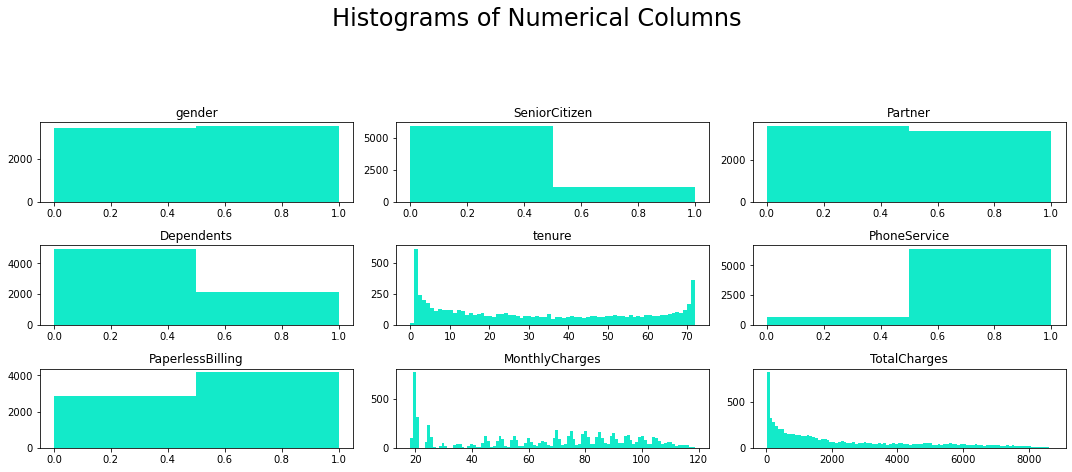

In [13]:
dataset2 = df[['gender', 'SeniorCitizen', 'Partner','Dependents','tenure', 'PhoneService', 'PaperlessBilling','MonthlyCharges', 'TotalCharges']]
#Histogram:
    
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 12))
plt.suptitle('Histograms of Numerical Columns\n', horizontalalignment="center", fontstyle="normal", fontsize=24, fontfamily="sans-serif")
for i in range(dataset2.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i])
    
    vals = np.size(dataset2.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
        
    plt.hist(dataset2.iloc[:, i], bins=vals, color='#13EAC9')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### From the graph, we can see that most of customers are young, most have phone service. Paperless billing is also quite in fasho for many of them
 

## Correlate the features with Churn

In [14]:
dataset2 = df[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges']]
correlations = dataset2.corrwith(df.Churn)
correlations = correlations[
correlations!=1]
positive_correlations = correlations[
correlations >0].sort_values(ascending = False)
negative_correlations =correlations[
correlations<0].sort_values(ascending = False)
print('Most Positive Correlations: \n', 
positive_correlations)
print('\nMost Negative Correlations: \n', 
negative_correlations)

Most Positive Correlations: 
 MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PhoneService        0.011942
dtype: float64

Most Negative Correlations: 
 gender         -0.008612
Partner        -0.150448
Dependents     -0.164221
TotalCharges   -0.199426
tenure         -0.352229
dtype: float64


Text(0.5, 1.0, 'Correlation with Churn Rate \n')

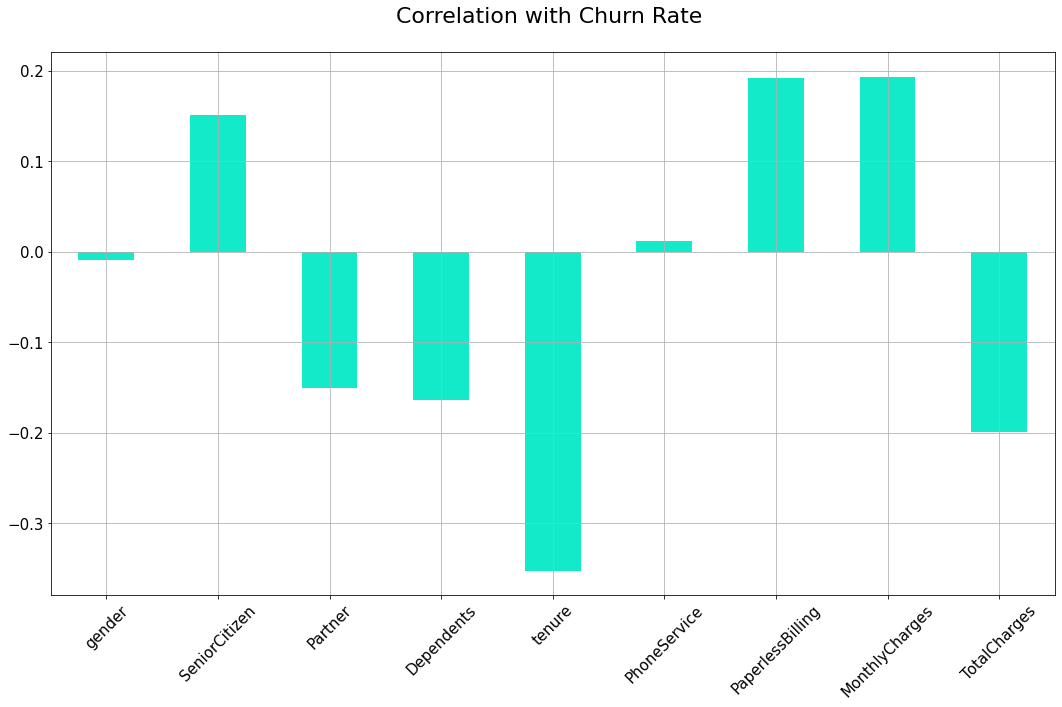

In [15]:
correlations = dataset2.corrwith(df.Churn)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color='#13EAC9',
        rot = 45, grid = True)
plt.title('Correlation with Churn Rate \n',
horizontalalignment="center", 
fontstyle = "normal", 
fontsize = "22", 
fontfamily = "sans-serif")

### We can see that there is a positive correlation between Churn and charges and age, while churns decrease and partner.

### Correlation matrix helps us to discover the bivariate relationship between independent variables in a dataset.

/var/folders/gy/f2zb846j5ggct3mwwm_kxcyr0000gn/T/ipykernel_3307/3003176978.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

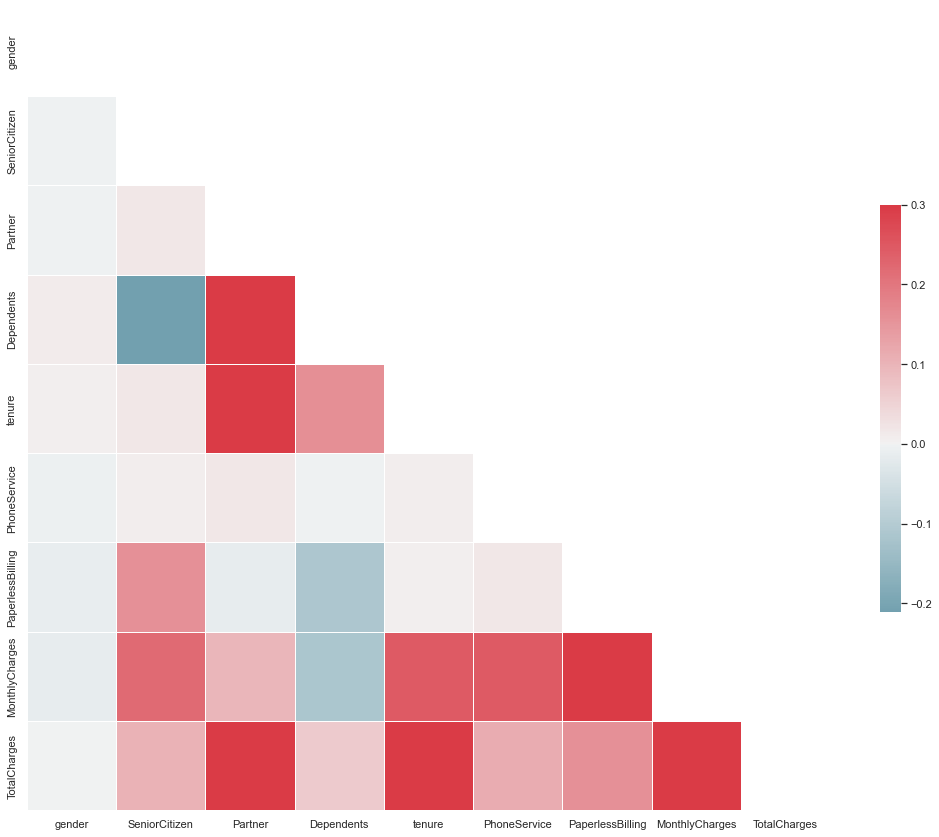

In [16]:
import seaborn as sn
#Set and compute the Correlation Matrix:

sn.set(style="white")
corr = dataset2.corr()
#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sn.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Check Multicollinearity using VIF

Variable Inflation Factors helps to find out the strength of the correlation of a variable with a group of other independent variables in a dataset. VIF starts usually at 1 and anywhere exceeding 10 indicates high multicollinearity between the independent variables.

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [
        variance_inflation_factor(
            X.values, i) 
        for i in range(X.shape[1])]
    return vif

dataset2 = df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','tenure', 'PhoneService','PaperlessBilling','MonthlyCharges', 'TotalCharges']]
calc_vif(dataset2)

,variables,VIF
0,gender,1.921286
1,SeniorCitizen,1.327766
2,Partner,2.815272
3,Dependents,1.921208
4,tenure,10.549667
5,PhoneService,7.976386
6,PaperlessBilling,2.814160
7,MonthlyCharges,13.988649
8,TotalCharges,12.570269


We can see that Monthly and Total charges have high values, so we should check their correlation

Text(0.5, 1.0, 'Collinearity of Monthly Charges and Total Charges \n')

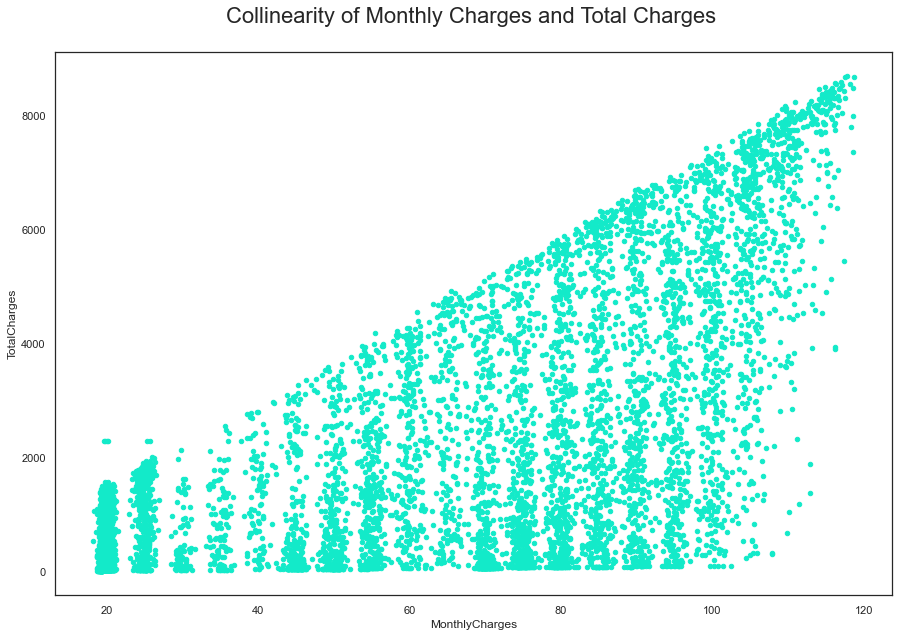

In [18]:
#Check colinearity:
    
dataset2[['MonthlyCharges', 'TotalCharges']].plot.scatter(figsize = (15, 10), x ='MonthlyCharges',y='TotalCharges', color =  '#13EAC9')
plt.title('Collinearity of Monthly Charges and Total Charges \n',
horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

So we can drop one of the variables to improve the data

In [ ]:
#Dropping 'TotalCharges':
    
dataset2 = dataset2.drop(columns = "TotalCharges")
#Revalidate Colinearity:
dataset2 = df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','tenure', 'PhoneService', 'PaperlessBilling','MonthlyCharges']]


Now it looks better!!!

In [21]:
calc_vif(dataset2)

,variables,VIF
0,gender,1.879536
1,SeniorCitizen,1.323089
2,Partner,2.814574
3,Dependents,1.908533
4,tenure,3.287603
5,PhoneService,5.963240
6,PaperlessBilling,2.745897
7,MonthlyCharges,7.453993


In [ ]:
#Applying changes in the main dataset:
    
df = df.drop(columns = "TotalCharges")

## Encode categorical data

In [22]:
#Incase if user_id is an object:
    
identity = df["customerID"]
df = df.drop(columns="customerID")

#Convert rest of categorical variable into dummy:

df= pd.get_dummies(df)

#Rejoin userid to dataset:
df = pd.concat([df, identity], axis = 1)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,customerID
0,0,0,1,0,1,0,1,29.85,0,0,...,0,0,1,0,0,0,0,1,0,7590-VHVEG
1,1,0,0,0,34,1,0,56.95,0,1,...,0,0,0,1,0,0,0,0,1,5575-GNVDE
2,1,0,0,0,2,1,1,53.85,1,1,...,0,0,1,0,0,0,0,0,1,3668-QPYBK
3,1,0,0,0,45,0,0,42.30,0,0,...,0,0,0,1,0,1,0,0,0,7795-CFOCW
4,0,0,0,0,2,1,1,70.70,1,1,...,0,0,1,0,0,0,0,1,0,9237-HQITU


## Split the dataset into dependent and independent variables:

In [23]:
#Identify response variable:
    
response = df["Churn"]
df = df.drop(columns="Churn")


## Generate training and test datasets:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df, response, stratify=response, test_size = 0.2)

#use 0.9 if data is huge.random_state = 0) 
#to resolve any class imbalance - use stratify parameter.
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset:", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (5634, 40)
Number transactions y_train dataset: (5634,)
Number transactions X_test dataset:  (1409, 40)
Number transactions y_test dataset:  (1409,)


In [25]:
train_identity = X_train['customerID'] 
X_train = X_train.drop(columns = ['customerID'])

test_identity = X_test['customerID']
X_test = X_test.drop(columns = ['customerID'])

### Perform feature scaling
Normalize the variables before conducting any machine learning (classification) algorithms so that all the training and test variables are scaled within a range of 0 to 1.

In [26]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

## Model selection

In [27]:
#sklearn modules for Model Selection:

from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [28]:
#sklearn modules for Model Evaluation & Improvement:
    
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer,recall_score, log_loss
from sklearn.metrics import average_precision_score

In [29]:
# Define models
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')),
    ('SVC', SVC(kernel='linear', random_state=0)),
    ('Kernel SVM', SVC(kernel='rbf', random_state=0)),
    ('KNN', KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)),
    ('Gaussian NB', GaussianNB()),
    ('Decision Tree Classifier', DecisionTreeClassifier(criterion='entropy', random_state=0)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0))
]

# Initialize lists to store results
acc_results = []
auc_results = []
names = []

# Set table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0

# Evaluate each model using k-fold cross-validation
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=0)  # Enable shuffling
    
    # Accuracy scoring
    cv_acc_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    
    # ROC AUC scoring
    cv_auc_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    
    # Populate the results table
    model_results.loc[i] = [
        name,
        round(cv_auc_results.mean() * 100, 2),
        round(cv_auc_results.std() * 100, 2),
        round(cv_acc_results.mean() * 100, 2),
        round(cv_acc_results.std() * 100, 2)
    ]
    i += 1

# Sort the results by ROC AUC Mean in descending order
model_results = model_results.sort_values(by='ROC AUC Mean', ascending=False)

# Display the results
print(model_results)


                  Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  \
0       Logistic Regression         84.19         2.04          74.48   
1                       SVC         83.77         2.24          80.28   
4               Gaussian NB         81.69         1.90          68.74   
6             Random Forest         80.91         2.20          78.08   
2                Kernel SVM         80.04         2.76          79.64   
3                       KNN         76.20         2.55          75.38   
5  Decision Tree Classifier         66.46         2.64          73.66   

   Accuracy STD  
0          1.90  
1          1.95  
4          1.38  
6          1.86  
2          1.85  
3          1.64  
5          1.71  


At this point, we need to visualize the accuracy of each model

No handles with labels found to put in legend.


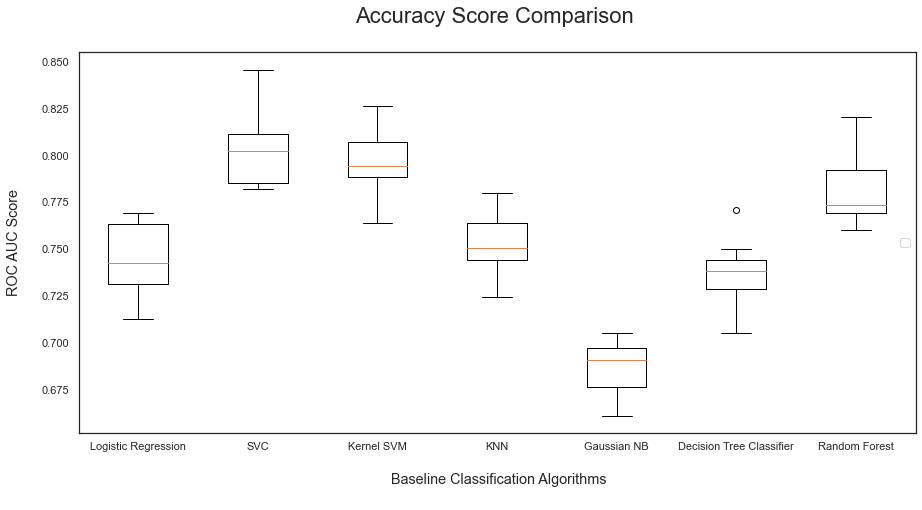

In [34]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")

plt.xlabel('\n Baseline Classification Algorithms\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")

plt.title('Accuracy Score Comparison \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

We can check also the ROC curve, Log-reg and e the best options

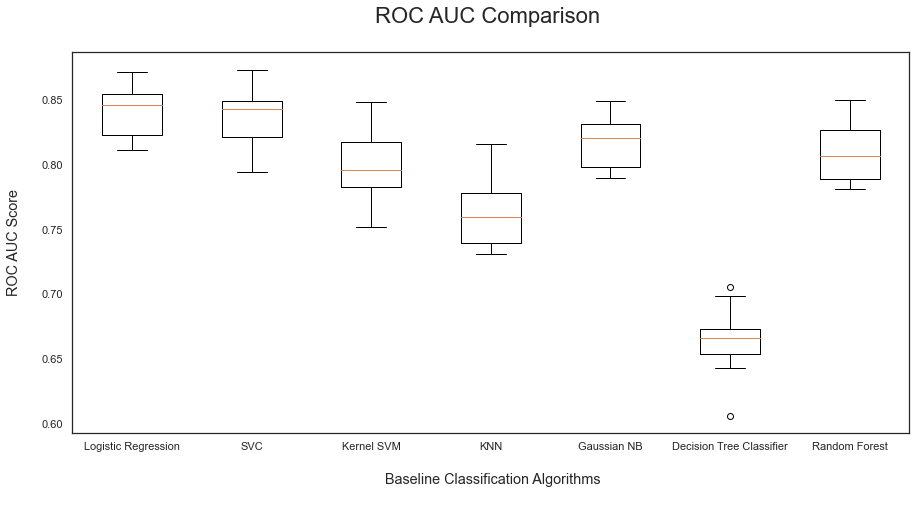

In [35]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score\n', horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")

plt.xlabel('\n Baseline Classification Algorithms\n', horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")

plt.title('ROC AUC Comparison \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")

plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Now, we want to optimize models to see if their accuracy could be better, and then make a second comparison

For KNN, we want to know what is the optimal K number, so the number of klusters.
We will write a loop and iterate 20 to 30 times and gives the accouracy score for each.

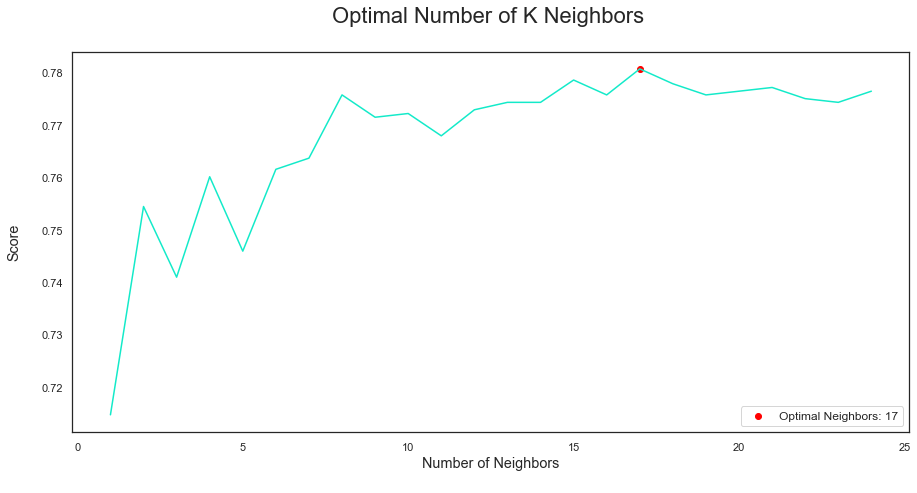

The optimal number of neighbors is: 17


In [43]:
score_array = []

# Train and evaluate the KNN model for different number of neighbors
for n_neighbors in range(1, 25):
    knn_loop = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_loop.fit(X_train, y_train)
    score_array.append(knn_loop.score(X_test, y_test))

# Find the optimal number of neighbors (top one)
optimal_neighbors = score_array.index(max(score_array)) + 1

# Plot the scores
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1, 25), score_array, color='#13EAC9')
plt.scatter(optimal_neighbors, max(score_array), color='red', label=f'Optimal Neighbors: {optimal_neighbors}')
plt.ylabel('Score\n', horizontalalignment="center", fontstyle="normal", fontsize="large", fontfamily="sans-serif")
plt.xlabel('Number of Neighbors\n', horizontalalignment="center", fontstyle="normal", fontsize="large", fontfamily="sans-serif")
plt.title('Optimal Number of K Neighbors \n', horizontalalignment="center", fontstyle="normal", fontsize="22", fontfamily="sans-serif")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.legend(loc='lower right', fontsize="medium")
plt.show()

print(f"The optimal number of neighbors is: {optimal_neighbors}")

For the Random Forest, we want to estimate the optimal number of decision threes

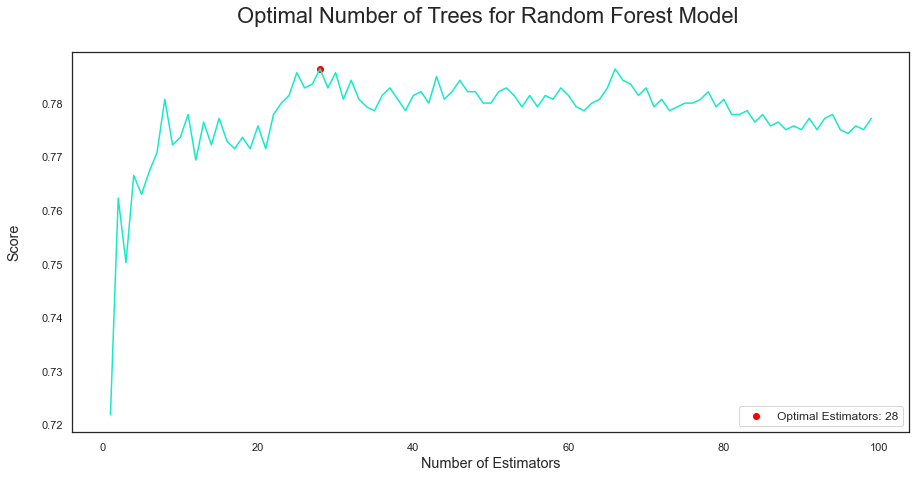

The optimal number of estimators is: 28


In [42]:
score_array = []

# Train and evaluate the random forest model for different number of estimators
for n_estimators in range(1, 100):
    rf_loop = RandomForestClassifier(n_estimators=n_estimators, random_state=1)
    rf_loop.fit(X_train, y_train)
    score_array.append(rf_loop.score(X_test, y_test))

# Find the optimal number of estimators (top one)
optimal_estimators = score_array.index(max(score_array)) + 1

# Plot the scores
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1, 100), score_array, color='#13EAC9')
plt.scatter(optimal_estimators, max(score_array), color='red', label=f'Optimal Estimators: {optimal_estimators}')
plt.ylabel('Score\n', horizontalalignment="center", fontstyle="normal", fontsize="large", fontfamily="sans-serif")
plt.xlabel('Number of Estimators\n', horizontalalignment="center", fontstyle="normal", fontsize="large", fontfamily="sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n', horizontalalignment="center", fontstyle="normal", fontsize="22", fontfamily="sans-serif")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.legend(loc='lower right', fontsize="medium")
plt.show()

print(f"The optimal number of estimators is: {optimal_estimators}")


With this info, we can go ahead and compare the models for a second time

In [45]:
# Define models
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')),
    ('SVC', SVC(kernel='linear', random_state=0)),
    ('Kernel SVM', SVC(kernel='rbf', random_state=0)),
    ('KNN', KNeighborsClassifier(n_neighbors=17, metric='minkowski', p=2)),
    ('Gaussian NB', GaussianNB()),
    ('Decision Tree Classifier', DecisionTreeClassifier(criterion='entropy', random_state=0)),
    ('Random Forest', RandomForestClassifier(n_estimators=28, criterion='entropy', random_state=0))
]

# Initialize lists to store results
acc_results = []
auc_results = []
names = []

# Set table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0

# Evaluate each model using k-fold cross-validation
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=0)  # Enable shuffling
    
    # Accuracy scoring
    cv_acc_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    
    # ROC AUC scoring
    cv_auc_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    
    # Populate the results table
    model_results.loc[i] = [
        name,
        round(cv_auc_results.mean() * 100, 2),
        round(cv_auc_results.std() * 100, 2),
        round(cv_acc_results.mean() * 100, 2),
        round(cv_acc_results.std() * 100, 2)
    ]
    i += 1

# Sort the results by ROC AUC Mean in descending order
model_results = model_results.sort_values(by='ROC AUC Mean', ascending=False)

# Display the results
print(model_results)


                  Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  \
0       Logistic Regression         84.19         2.04          74.48   
1                       SVC         83.77         2.24          80.28   
4               Gaussian NB         81.69         1.90          68.74   
3                       KNN         80.89         2.05          77.21   
2                Kernel SVM         80.04         2.76          79.64   
6             Random Forest         79.99         2.19          77.81   
5  Decision Tree Classifier         66.46         2.64          73.66   

   Accuracy STD  
0          1.90  
1          1.95  
4          1.38  
3          1.55  
2          1.85  
6          1.63  
5          1.71  


### Logistic Regression stands out, so that is the model we will select!

We will try to find out the best hyperparameter to be tuned and test the performances of our model with the best ones.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = [
    {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['none']}
]
# Instantiate the logistic regression classifier
classifier = LogisticRegression(random_state=0)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Re-instantiate the logistic regression classifier with the best parameters
classifier = LogisticRegression(random_state=0, **best_params)

# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = classifier.predict(X_test)

# Evaluate Model Results on Test Set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

# Create a DataFrame to store the results
results = pd.DataFrame([['Logistic Regression (Tuned)',
                          acc, prec, rec, f1, f2]],
                       columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

print(results)
print("Best Parameters:", best_params)
print("Best Score:", best_score)

                         Model  Accuracy  Precision    Recall  F1 Score  \
0  Logistic Regression (Tuned)  0.801987   0.648903  0.553476  0.597403   

   F2 Score  
0  0.570248  
Best Parameters: {'C': 1, 'penalty': 'l2'}
Best Score: 0.8047582273313989


## K-fold validation

k-fold cross-validation basically split the training set into 10 folds and train the model on 9 folds (9 subsets of the training dataset) before testing it on the test fold.
This helps us to avoid issue such as different performances on different sets of data

In [51]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Logistic Regression Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Logistic Regression Classifier Accuracy: 0.80 (+/- 0.03)


This Method tells us that our model has an accouracy of 80% with a deviation of ±3%

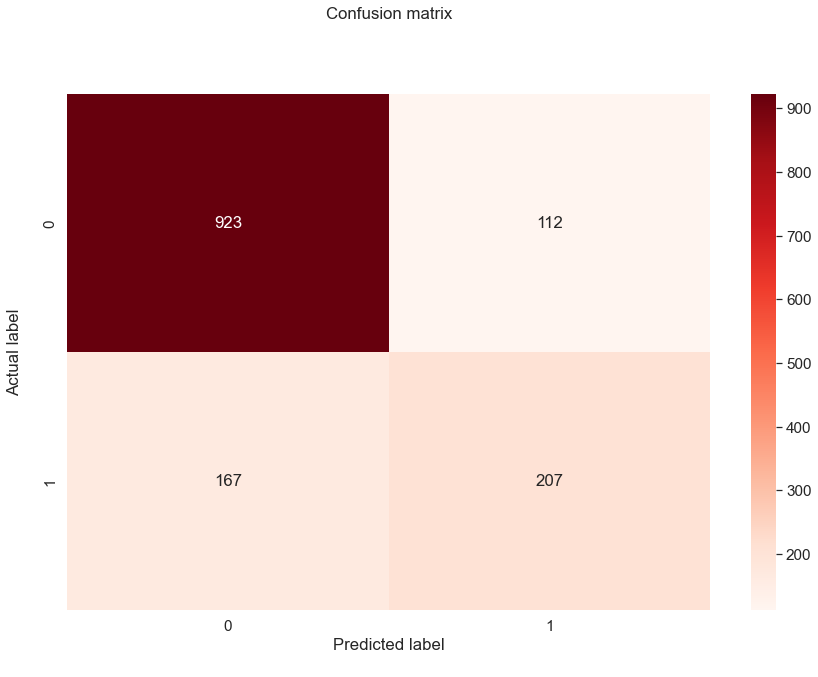

In [55]:
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])

plt.figure(figsize=(12, 8))  # Adjust figsize to make the figure bigger
sn.set(font_scale=1.4)
heatmap = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Reds")  # Use a reddish colormap

# Center the plot
heatmap.set_xticklabels(heatmap.get_xticklabels(), ha='center')
heatmap.set_yticklabels(heatmap.get_yticklabels(), va='center')

plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
plt.show()


## ROC curve
The importance of the ROC curve lies in its ability to provide a comprehensive understanding of the trade-off between sensitivity (true positive rate) and specificity (true negative rate) at various threshold levels. This curve helps in selecting the optimal threshold for class prediction based on the specific requirements of the application. A model with a higher AUC-ROC score generally indicates better discrimination ability, making it a useful tool for evaluating and comparing different classification models. Additionally, the ROC curve is robust to class imbalance and is widely used in various fields, including medicine, finance, and machine learning.

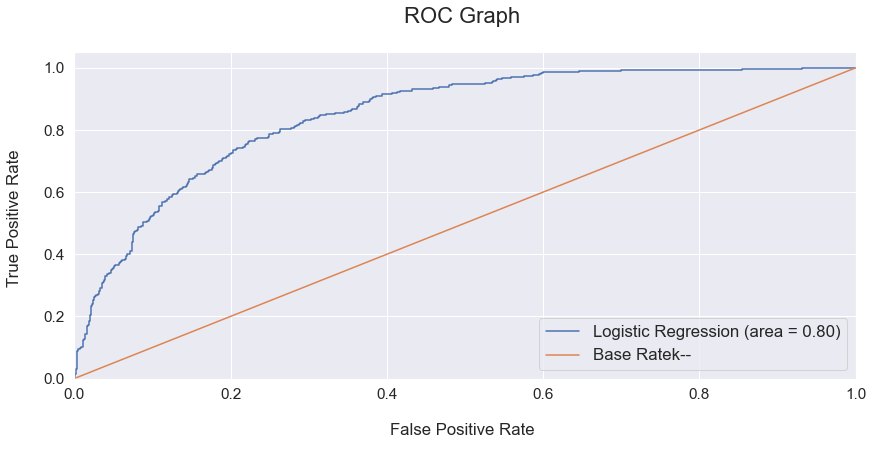

In [56]:
classifier.fit(X_train, y_train) 
probs = classifier.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Logistic Regression (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Now, this model allows us to rank our predictors according to their importance and effect on the Churn

In [58]:
feature_importances = pd.concat([pd.DataFrame(df.drop(columns = 'customerID').columns, columns = ["features"]),
pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])],axis = 1)
feature_importances.sort_values("coef", ascending = False)

,features,coef
12,InternetService_Fiber optic,0.363743
32,Contract_Month-to-month,0.280030
31,StreamingMovies_Yes,0.157997
28,StreamingTV_Yes,0.148583
6,PaperlessBilling,0.136999
10,MultipleLines_Yes,0.111654
37,PaymentMethod_Electronic check,0.106546
14,OnlineSecurity_No,0.097013
23,TechSupport_No,0.087064
1,SeniorCitizen,0.078591


When predicting the churn rate, we can see that churn would increase if customers have fiber optic contract and month to month contract. On the other hand, churn will decrease with duration (tenure) and depending on the monthly charges. 

Finally, we can add the probability to churn for each customer. 

In [63]:
lr_classifier = LogisticRegression(random_state = 0, penalty = 'l2')
lr_classifier.fit(X_train, y_train)
#probability score
y_pred_probs = lr_classifier.predict_proba(X_test)
y_pred_probs  = y_pred_probs [:, 1]

final_results = pd.concat([test_identity, y_test], axis = 1).dropna()
final_results['predictions'] = y_pred
final_results["propensity_to_churn(%)"] = y_pred_probs
final_results["propensity_to_churn(%)"] = final_results["propensity_to_churn(%)"]*100
final_results["propensity_to_churn(%)"]=final_results["propensity_to_churn(%)"].round(2)
final_results = final_results[['customerID', 'Churn', 'predictions', 'propensity_to_churn(%)']]
final_results ['Ranking'] = pd.qcut(final_results['propensity_to_churn(%)'].rank(method = 'first'),10,labels=range(10,0,-1))
print(final_results)

      customerID  Churn  predictions  propensity_to_churn(%) Ranking
57    5067-XJQFU      0            0                   15.34       6
1345  2293-IJWPS      0            0                   20.67       5
5889  9693-XMUOB      0            0                   26.00       5
4425  3059-NGMXB      0            0                   22.55       5
135   7799-LGRDP      0            0                    2.55       9
...          ...    ...          ...                     ...     ...
5369  9860-LISIZ      0            0                    6.20       7
5062  2911-UREFD      1            0                   25.62       5
1611  1971-DTCZB      0            0                    1.57       9
922   4301-VVZKA      0            1                   63.70       2
6836  5868-YWPDW      1            1                   72.70       1

[1409 rows x 5 columns]


In [66]:
import joblib
# Save the trained model to a file
joblib.dump(lr_classifier, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']